In [1]:
!screenfetch

                          ./+o+-       ivb@cds2
                  yyyyy- -yyyyyy+      OS: Ubuntu 18.04 bionic
               ://+//////-yyyyyyo      Kernel: x86_64 Linux 4.15.0-74-generic
           .++ .:/++++++/-.+sss/`      Uptime: 3h 57m
         .:++o:  /++++++++/:--:/-      Packages: 3045
        o:+o+:++.`..```.-/oo+++++/     Shell: sh
       .:+o:+o/.          `+sssoo+/    CPU: Intel Xeon Gold 6154 @ 16x 3GHz
  .++/+:+oo+o:`             /sssooo.   GPU: Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB, Tesla V100-SXM2-32GB
 /+++//+:`oo+o               /::--:.   RAM: 31178MiB / 128933MiB
 \+/+o+++`o++o               ++////.  
  .++.o+++oo+:`             /dddhhh.  
       .+.o+oo:.          `oddhhhh+   
        \+.++o+o``-````.:ohdhhhhh+    
         `:o+++ `ohhhhhhhhyo++os:     
           .o:`.syhhhhhhh/.oo++o`     
               /osyyyyyyo++ooo+++/    
                   ````` +oo+++o\:    
                          `oo++.      


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import numpy as np
import json
import config as C
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from utils import parse_camera_intrinsic as parse_camera_intrinsic
from scipy.spatial.transform import Rotation as R
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision import transforms as T
from torch import nn
from tqdm import tqdm

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [5]:
with open(C.TRAIN_CROPS_JSON, "r") as f:
    train_gt = json.load(f)

In [6]:
train_gt["annotations"][0]

{'id': 1,
 'image_id': 0,
 'category_id': 47,
 'bbox': [1723.0, 1776.0, 29.0, 26.0],
 'position': [3.8249, 31.7701, 168.57],
 'orientation': [0.0063812, -0.184722, 3.13912],
 'orientation_relative': [0.006918107352997232,
  -0.18451171371342667,
  3.139121365067781]}

In [7]:
class PKURegressionDataset(Dataset):
    
    def __init__(self, orientation_field, images_dir, max_size, transforms=None):
        super().__init__()
        self.orientation_field = orientation_field
        self.images_dir = images_dir
        self.max_size = max_size
        self.transforms = transforms
        
        with open(C.TRAIN_CROPS_JSON, "r") as f:
            self.gt = json.load(f)
        
        cat_ids = set(ann['category_id'] for ann in self.gt['annotations'])
        categories = [cat for cat in self.gt['categories'] if cat['id'] in cat_ids]
        self.category_id_to_label = {
            cat["id"]: label
            for label, cat in enumerate(sorted(categories, key=lambda x: x["id"]))
        }
        self.image_id_to_path = {
            image["id"]: os.path.join(images_dir, image["file_name"]) 
            for image in self.gt["images"]
        }
        self.p = parse_camera_intrinsic()
        for k in self.p:
            self.p[k] = float(self.p[k])
    
    def __len__(self):
        return len(self.gt["annotations"])
    
    def __getitem__(self, idx):
        image = self.load_image(idx)
        label = self.get_label(idx)
        bbox_x, bbox_y, bbox_w, bbox_h = self.get_bbox(idx)
        bbox_center_x, bbox_center_y = bbox_x + bbox_w / 2, bbox_y + bbox_h / 2
        wx, wy, wz = self.get_position(idx)
        orientation = self.get_orientation(idx)
        
        result =  dict(
            image=image,
            label=label,
            bbox=np.array([(bbox_center_x-self.p["cx"])/self.p["fx"], (bbox_center_y-self.p["cy"])/self.p["fy"], bbox_w/self.p["fx"], bbox_h/self.p["fy"]]),
            position=np.array([wx, wy, wz]),
            distance=np.sqrt(wx**2 + wy**2 + wz**2),
            orientation=np.array(orientation)
        )
        if self.transforms is not None:
            result['image'] = self.transforms(result['image'])
        return result
    
    def load_image(self, idx):
        
        image_id = self.gt["annotations"][idx]["image_id"]
        path = self.image_id_to_path[image_id]
        image = Image.open(path)
        w, h = image.size
        scale = self.max_size / max(w, h)
        w_new, h_new = int(w * scale), int(h * scale)
        image = image.resize((w_new, h_new), Image.LANCZOS)
        new_image = Image.new("RGB", (self.max_size, self.max_size))
        new_image.paste(image, ((self.max_size - w_new) // 2, (self.max_size - h_new) // 2))
        return new_image
        
    def get_label(self, idx):
        return self.category_id_to_label[self.gt["annotations"][idx]["category_id"]]
    
    def get_bbox(self, idx):
        return self.gt["annotations"][idx]["bbox"]
    
    def get_position(self, idx):
        return self.gt["annotations"][idx]["position"]
    
    def get_orientation(self, idx):
        euler_angles = self.gt["annotations"][idx][self.orientation_field]
        rotation = R.from_euler("YXZ", euler_angles)
        q = rotation.as_quat()
        e = np.array([0,0,1])
        q[:3] = q[:3] * np.dot(e, q[:3]) / (np.abs(np.dot(q[:3], e)))
        return q

In [8]:
transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [9]:
ds = PKURegressionDataset("orientation", C.TRAIN_CROPS_ORIGIN, 256, transforms)

In [10]:
len(ds)

49115

In [11]:
r = ds[3]

In [12]:
r["image"].shape

torch.Size([3, 256, 256])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


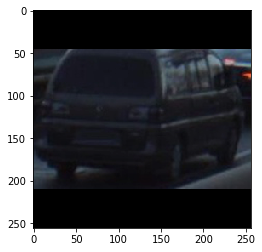

In [13]:
plt.imshow((np.transpose(r["image"].numpy(), (1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])))

In [14]:
r

{'image': tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044,

In [15]:
dl = DataLoader(ds, batch_size=32, shuffle=True, drop_last=True, pin_memory=True)

In [16]:
for batch in dl:
    break

In [17]:
batch

{'image': tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
    

In [18]:
len(ds.category_id_to_label)

34

In [19]:
batch['image'].shape

torch.Size([32, 3, 256, 256])

In [20]:
class ConvBnAct(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, (3, 3), padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(inplace=True)
        
        nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu')
        nn.init.constant_(self.conv.bias, 0)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x

class Model(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet101(pretrained=True)
        
        self.local_neck = nn.Sequential(
            ConvBnAct(2048, 512),
            ConvBnAct(512, 256),
            ConvBnAct(256, 64),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 1024),  # 4
            nn.LeakyReLU(inplace=True),
            nn.Linear(1024, 1024),  # 6
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.local_neck[4].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[4].bias, 0)
        nn.init.kaiming_normal_(self.local_neck[6].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.local_neck[6].bias, 0)
        
        self.cls_head = nn.Linear(1024, 34)
        nn.init.kaiming_normal_(self.cls_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.cls_head.bias, 0)
        
        self.rot_head = nn.Linear(1024, 4)
        nn.init.kaiming_normal_(self.rot_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.rot_head.bias, 0)
        
        self.trans_neck = nn.Sequential(
            nn.Linear(4, 100),  # 0
            nn.LeakyReLU(inplace=True),
            nn.Linear(100, 100),  # 2
            nn.LeakyReLU(inplace=True),
        )
        nn.init.kaiming_normal_(self.trans_neck[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_neck[0].bias, 0)
        nn.init.kaiming_normal_(self.trans_neck[2].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_neck[2].bias, 0)
        
        self.ln_to_trans = nn.Sequential(
            nn.Linear(1024, 100),  # 0
            nn.LeakyReLU(inplace=True)
        )
        nn.init.kaiming_normal_(self.ln_to_trans[0].weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.ln_to_trans[0].bias, 0)
        
        self.trans_head = nn.Linear(200, 3)
        nn.init.kaiming_normal_(self.trans_head.weight, nonlinearity='leaky_relu')
        nn.init.constant_(self.trans_head.bias, 0)
        
    def extract_features(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)
        
        return x
    
    def forward(self, x,bbox):
        features = self.extract_features(x)
        ln = self.local_neck(features)

        translation_v1 = self.trans_neck(bbox)
        ln_to_trans_n = self.ln_to_trans(ln)
        #rint((translation_v1.shape,ln_to_trans_n.shape))
        translation = self.trans_head(torch.cat((translation_v1,ln_to_trans_n),dim=-1))
        
        cls_score = self.cls_head(ln)
        orientation = self.rot_head(ln)
        
        return dict(cls_score=cls_score, orientation = orientation, translation = translation)

In [21]:
model = Model()

In [22]:
sum(p.nelement() for p in model.parameters())

60713525

In [23]:
sum(p.nelement() for p in model.backbone.parameters())

44549160

outputs = model(batch['image'])

outputs

 torch.norm(outputs['orientation'], dim=-1, keepdim=True)

In [24]:
def huber_loss(bbox_pred, bbox_targets, beta=2.8):
    """
    SmoothL1(x) = 0.5 * x^2 / beta      if |x| < beta
                  |x| - 0.5 * beta      otherwise.
    https://en.wikipedia.org/wiki/Huber_loss
    """
    box_diff = bbox_pred - bbox_targets

    dis_trans = torch.norm(box_diff, dim=1)
    # dis_trans = np.linalg.norm(box_diff.data.cpu().numpy(), axis=1)
    # we also add a metric for dist<2.8 metres.
    inbox_idx = dis_trans <= 2.8
    outbox_idx = dis_trans > 2.8

    # bbox_inside_weights = torch.from_numpy(inbox_idx.astype('float32')).cuda()
    # bbox_outside_weights = torch.from_numpy(outbox_idx.astype('float32')).cuda()
    bbox_inside_weights = inbox_idx.float()
    bbox_outside_weights = outbox_idx.float()

    in_box_pow_diff = 0.5 * torch.pow(box_diff, 2) / beta
    in_box_loss = in_box_pow_diff.sum(dim=1) * bbox_inside_weights

    out_box_abs_diff = torch.abs(box_diff)
    out_box_loss = (out_box_abs_diff.sum(dim=1) - beta / 2) * bbox_outside_weights

    loss_box = in_box_loss + out_box_loss
    N = loss_box.size(0)  # batch size
    loss_box = loss_box.view(-1).sum(0) / N
    return loss_box

In [25]:
def loss_fn(outputs, batch):
    cls_loss = nn.functional.cross_entropy(outputs['cls_score'], batch['label'])
    normed = outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)
#     e = torch.FloatTensor([0, 0, 1]).cuda()
#     prod = (normed[:, :3] * e).sum(dim=1)
#     normed2 = torch.cat((torch.unsqueeze(prod / torch.abs(prod), 1) * normed[:, :3], normed[:, 3:4]), dim=1)
    rot_loss_old = nn.functional.l1_loss(normed, batch['orientation'])
#    translation_loss = nn.SmoothL1Loss
    rot_loss = (normed[:, -1] * batch['orientation'][:, -1] + \
               (normed[:, :-1] * batch['orientation'][:, :-1]).sum(dim=1)).mean()
    trans_loss = huber_loss(outputs['translation'],batch['position'])
    loss = trans_loss 
    return dict(loss=loss, cls_loss=rot_loss_old, rot_loss=1-rot_loss, trans_loss = trans_loss)

In [26]:
model = model.cuda()

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

sd = optimizer.state_dict()
sd['param_groups'][0]['lr'] = 0.0001
optimizer.load_state_dict(sd)

sd['param_groups'][0]['lr']

In [28]:
losses = []

In [29]:
pbar = tqdm(total=len(dl))

  0%|          | 0/1534 [00:00<?, ?it/s]

In [30]:
def smooth(beta, array):
    s=[]
    s.append(array[0])
    for i in range(1,len(array)):
        s.append((1-beta)*s[-1]+beta*array[i])
    return s

In [47]:
#pbar = tqdm(total=len(dl))
for i in range(1):
    for batch in dl:
        for k in batch:
            if k == 'label':
                batch[k] = batch[k].long()
            else:
                batch[k] = batch[k].float()
            batch[k] = batch[k].cuda()
        outputs = model(batch['image'],batch['bbox'])
        loss = loss_fn(outputs, batch)
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        for k in loss:
            loss[k] = loss[k].item()
        losses.append(loss)
        pbar.update()
        pbar.set_description("{:.5f} {:.5f} {:.5f} {:.5f} ".format(loss['loss'], loss['cls_loss'], loss['rot_loss'], loss['trans_loss']))

5.25116 0.70995 1.47652 5.25116 : : 4602it [53:14,  1.47it/s]    

In [28]:
model.load_state_dict(torch.load("stupid_1501_model.pth"))

<All keys matched successfully>

In [29]:
s = 0
for batch in tqdm(dl):
    for k in batch:
        if k == 'label':
            batch[k] = batch[k].long()
        else:
            batch[k] = batch[k].float()
        batch[k] = batch[k].cuda()
    with torch.no_grad():
        outputs = model(batch['image'],batch['bbox'])
    dis_trans = torch.norm(batch['position'] - outputs['translation'], dim = 1 )
    s+=(dis_trans < 0.1).long().sum().item()
print(s/len(ds))

100%|██████████| 1534/1534 [10:19<00:00,  2.63it/s]

0.00022396416573348266


In [30]:
print(s)

11


In [50]:
torch.save(model.state_dict(), "stupid_1501_model.pth")
torch.save(optimizer.state_dict(), "stupid_1501_optim.pth")

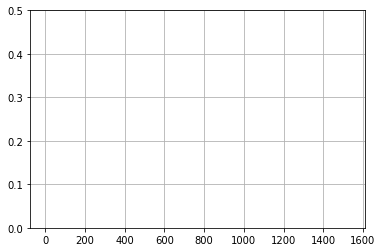

In [32]:
plt.plot([l["cls_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["cls_loss"] for l in losses]))
plt.ylim((0,0.5))
plt.grid()

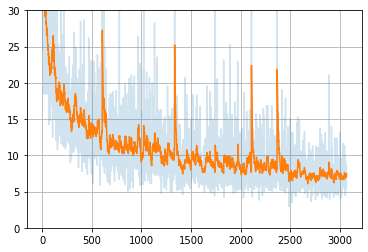

In [44]:
# lr = 0.0001
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

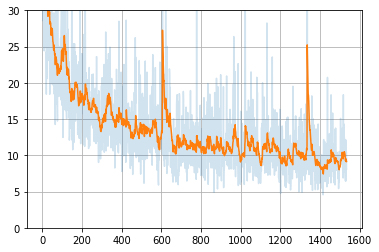

In [34]:
# lr = 0.001
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

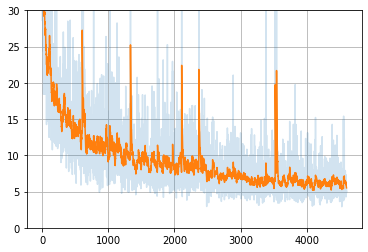

In [48]:
# lr = 0.001, LeakyReLU
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

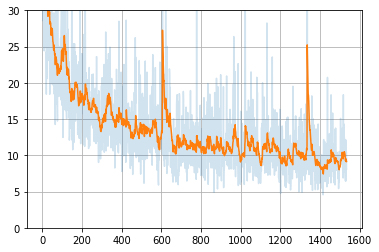

In [36]:
# lr = 0.001, ReLU, xavier_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

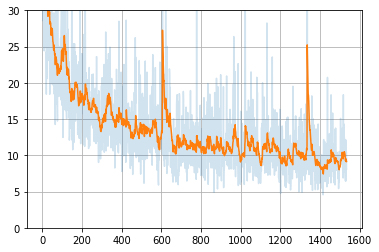

In [37]:
# lr = 0.001, ReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

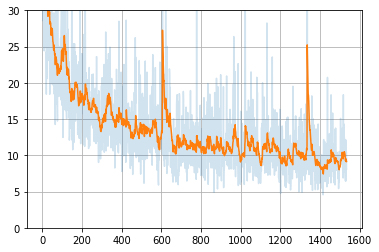

In [38]:
# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,30))
plt.grid()

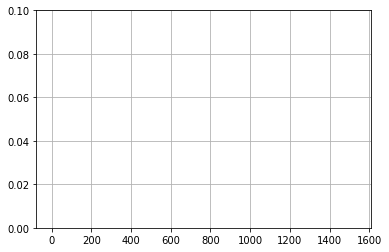

In [39]:
# lr = 0.001, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

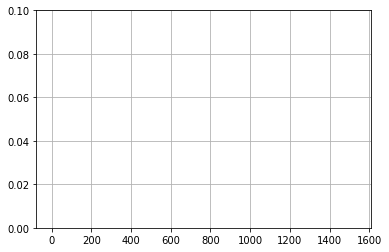

In [40]:
# lr = 1E-6, LeakyReLU, kaiming_normal + constant
plt.plot([l["trans_loss"] for l in losses], alpha=0.2)
plt.plot(smooth(0.1, [l["trans_loss"] for l in losses]))
plt.ylim((0,0.1))
plt.grid()

In [41]:
batch['position']

tensor([[  0.9715,  10.2677,  52.6250],
        [ -5.1611,   3.3153,  13.0684],
        [ 13.3450,  17.3639,  95.6653],
        [  1.3535,   7.2706,  36.1182],
        [ 23.9238,  24.6501, 133.9880],
        [ 39.1876,  12.7158,  56.0081],
        [-11.9792,   5.3000,  25.6193],
        [-23.7771,  15.0668,  91.4483],
        [  3.1462,   3.5019,  13.3995],
        [ -9.8934,   3.5457,  13.9921],
        [ 12.5112,   9.4120,  46.7156],
        [ -0.4235,   8.3956,  46.0491],
        [ -0.1888,   6.6921,  32.9357],
        [-16.5908,   6.6929,  35.5071],
        [-11.8478,   7.2559,  41.6835],
        [-21.0399,  15.9676,  99.1230],
        [  4.7226,   6.1759,  27.2343],
        [ 21.7381,   9.4025,  50.4439],
        [-15.0878,   8.5627,  46.6871],
        [  5.1678,  24.3439, 143.4470],
        [ 21.5083,  11.9634,  56.3446],
        [ -9.6294,  14.4852,  82.6147],
        [-24.2136,  23.7430, 138.8920],
        [ -0.2850,   3.8879,  17.7998],
        [ -7.2880,   5.6932,  25.4758],


In [42]:
outputs['translation']

tensor([[ 1.9854e+00,  1.0080e+01,  4.8428e+01],
        [-5.5262e+00,  3.3472e+00,  1.4107e+01],
        [ 1.2380e+01,  1.4674e+01,  8.2138e+01],
        [ 1.3242e+00,  7.2969e+00,  3.6771e+01],
        [ 1.4658e+01,  1.8452e+01,  1.0492e+02],
        [ 3.4430e+01,  1.2375e+01,  5.6322e+01],
        [-1.1970e+01,  4.6669e+00,  2.6410e+01],
        [-1.9984e+01,  1.2143e+01,  7.4136e+01],
        [ 3.3614e+00,  2.8344e+00,  1.3929e+01],
        [-1.1645e+01,  2.9591e+00,  1.3983e+01],
        [ 1.3840e+01,  8.8167e+00,  3.9731e+01],
        [ 1.1824e-02,  8.7539e+00,  4.5746e+01],
        [-1.4927e-01,  7.7627e+00,  3.7195e+01],
        [-1.5868e+01,  6.3586e+00,  3.4880e+01],
        [-1.3683e+01,  7.6744e+00,  4.0514e+01],
        [-1.7699e+01,  1.3877e+01,  8.3436e+01],
        [ 4.2523e+00,  6.0404e+00,  2.4339e+01],
        [ 1.9573e+01,  8.3661e+00,  3.8968e+01],
        [-1.4854e+01,  7.1976e+00,  3.6541e+01],
        [ 4.6754e+00,  1.9667e+01,  1.1159e+02],
        [ 2.0619e+01

torch.save(model.state_dict(), "scare_model.pth")
torch.save(optimizer.state_dict(), "scare_optim.pth")

batch['orientation']

outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True)

torch.sum(torch.abs(outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']), dim=1)

torch.sum((outputs['orientation'] / torch.norm(outputs['orientation'], dim=-1, keepdim=True) - batch['orientation']) ** 2, dim=1) ** 0.5

batch['label']

torch.argmax(outputs['cls_score'], dim=1)

model.backbone

nn.Sequential

import pandas as pd

df = pd.read_csv(C.TRAIN_CSV)

df.head()

import utils

train_anns = utils.load_train_annotations()

train_anns["ID_8a6e65317"]

orientations_euler = []
for k, v in train_anns.items():
    for y, p, r in zip(v["yaws"], v["pitches"], v["rolls"]):
        orientations_euler.append((-p, -y, -r))

len(orientations_euler)

from scipy.spatial.transform import rotation as R

euler_angles = self.gt["annotations"][idx][self.orientation_field]
rotation = R.from_euler("XYZ", euler_angles)
q = rotation.as_quat()

def quaternion_to_euler_angle(q):

    """Convert quaternion to euler angel.
    Input:
        q: 1 * 4 vector,
    Output:
        angle: 1 x 3 vector, each row is [roll, pitch, yaw]
    """
    w, x, y, z = q
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

def euler_angles_to_quaternions(angle):
    """Convert euler angels to quaternions representation.
    Input:
        angle: n x 3 matrix, each row is [roll, pitch, yaw]
    Output:
        q: n x 4 matrix, each row is corresponding quaternion.
    """

    in_dim = np.ndim(angle)
    if in_dim == 1:
        angle = angle[None, :]

    n = angle.shape[0]
    roll, pitch, yaw = angle[:, 0], angle[:, 1], angle[:, 2]
    q = np.zeros((n, 4))

    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)

    q[:, 0] = cy * cr * cp + sy * sr * sp
    q[:, 1] = cy * sr * cp - sy * cr * sp
    q[:, 2] = cy * cr * sp + sy * sr * cp
    q[:, 3] = sy * cr * cp - cy * sr * sp

    return q

orientations_euler = np.array(orientations_euler)

orientations_quat = euler_angles_to_quaternions(orientations_euler[:, ::-1])

orientations_quat[:30]

for q in orientations_quat[:100]:
    print(q)

orientations_quat[0]

((orientations_quat[2][1:] / np.sin(np.arccos(orientations_quat[2][0]))) ** 2).sum()

((orientations_quat[2][:-1] / np.sin(np.arccos(orientations_quat[2][-1]))) ** 2).sum()